In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

category =  "config2"

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [3]:
run = 46
probes_dir = f'{scratch_dir}/CHARLES/{category}/R{run}/probes/probesOut'
oak_probes_dir =  f'{home_dir}/CHARLES/{category}/R{run}/probes/probesOut_parquet/'

In [4]:
# probes = probePost.Probes(probes_dir, directory_parquet=oak_probes_dir, file_type = "csv")
# probes.to_parquet(overwrite=True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, file_type = "parquet")

nameKey = read_probes_file_switch(f"{probes_dir}/../locations/nameKey_extraProbe.txt")
nameKey = nameKey.compute()


extraProbe = nameKey.copy()
extraProbe = pd.concat([extraProbe, probes.locations["extraProbe"]], axis = "columns")
for qoi in ["comp(u_avg,0)", "comp(u_avg,1)", "comp(u_avg,2)"]:
    df = probePost.ddf_to_pdf(probes.data[("extraProbe", qoi)]).iloc[-1]
    df.name = qoi
    extraProbe = pd.concat([extraProbe, df], axis = "columns")
extraProbe.set_index(0, inplace=True)
extraProbe = extraProbe.rename(columns=lambda x: f"EP_{x}")
extraProbe = extraProbe.rename(index=lambda x: x.replace("extraProbe_", ''))
display(extraProbe)

del probes

,EP_x,EP_y,EP_z,"EP_comp(u_avg,0)","EP_comp(u_avg,1)","EP_comp(u_avg,2)"
0,,,,,,
roof_sl,44.00,12.0,60.00,0.903852,0.045342,1.077090
xwindow_0-0_sl,36.55,1.5,58.00,0.081421,-0.152485,0.870609
zwindow_0-0_sl,40.00,1.5,54.55,0.623834,-0.048749,0.131952
xwindow_0-1_sl,36.55,1.5,62.00,-0.146850,-0.259822,0.850690
zwindow_0-1_sl,40.00,1.5,65.45,0.327162,-0.273910,0.017727
...,...,...,...,...,...,...
zwindow_0-1_h_0-2_Bxz,-56.00,1.5,-113.45,0.653699,-0.108030,-0.087738
zwindow_1-0_h_0-2_Bxz,-60.00,1.5,-102.55,-0.013746,0.080574,-0.230858
zwindow_1-1_h_0-2_Bxz,-60.00,1.5,-113.45,0.734194,-0.125748,-0.000052


In [5]:
qoisOutputed = [
    "mass_flux",
    "mass_flux(p)",
    "mass_flux(T)",
    "mass_flux(D)",
    "mass_flux(S)",
    "sn_prod(u)",
    "sn_prod(p)",
    "sn_prod(abs(u))",
    "sn_prod(u**2)"
]
qois= ["mass_flux"]

# probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type="csv")
# probes.to_parquet(overwrite = True)

probes = probePost.Probes(probes_dir, directory_parquet = oak_probes_dir, probe_type = "FLUX_PROBES", flux_quants = qoisOutputed, file_type = "parquet")



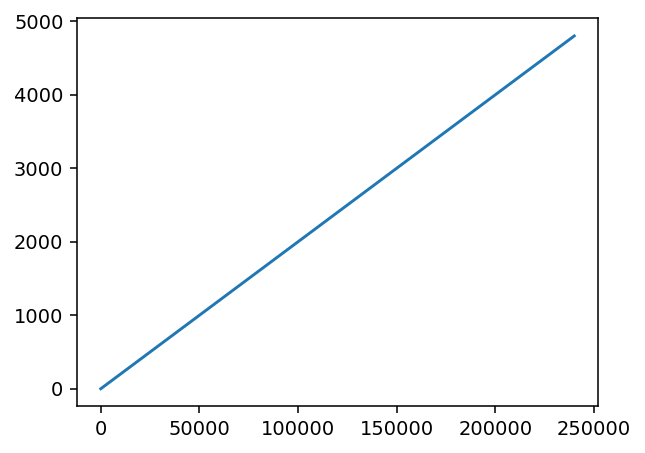

In [6]:
plt.figure()
plt.plot(probes.probe_steps, probes.probe_times)
plt.show()

In [7]:
starts = [40000, 160000]
stops = [120000, -1]
by = 1

## Convergence

In [8]:
@utils.no_kwargs
@utils.dict_apply
def sma(df): 
    return df.rolling(20000).mean()

processing data took 61 seconds
processing data took 26 seconds


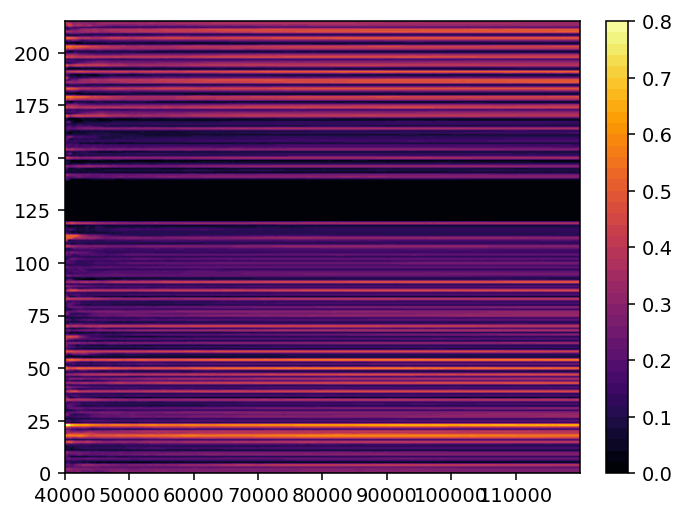

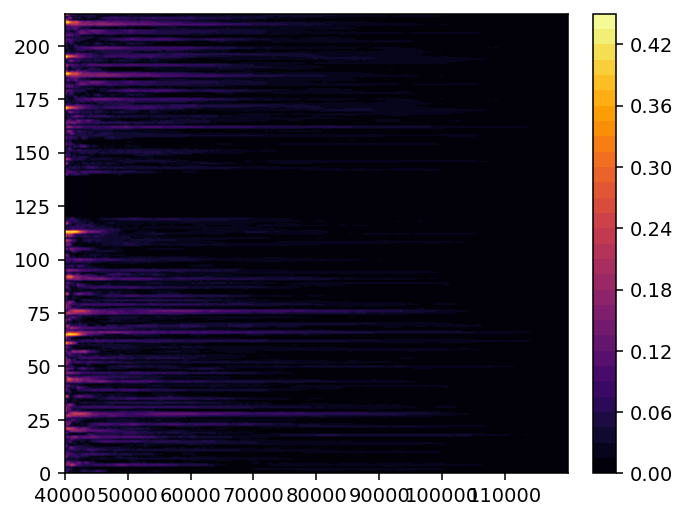

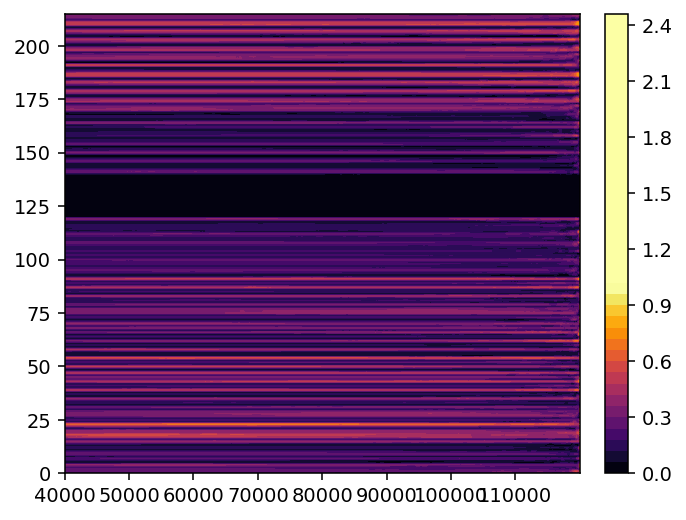

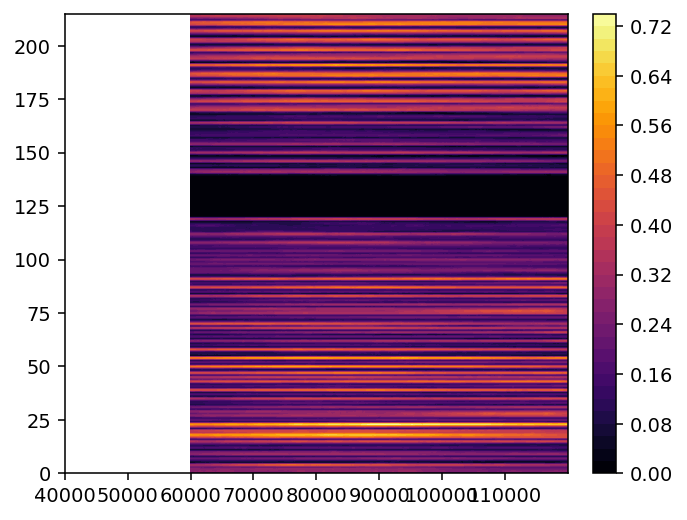

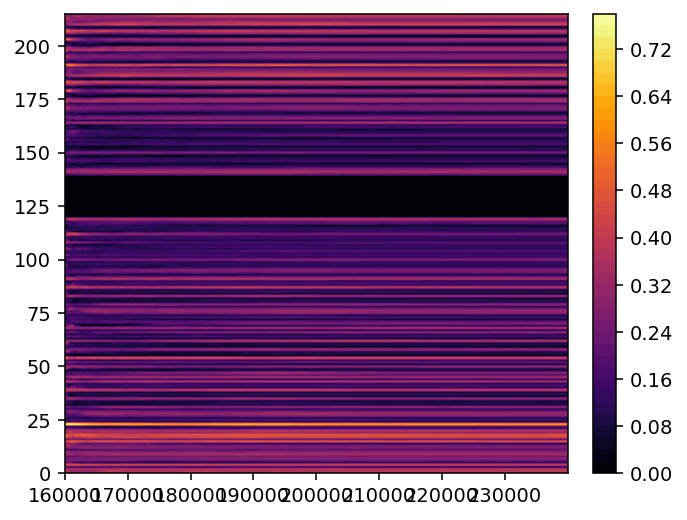

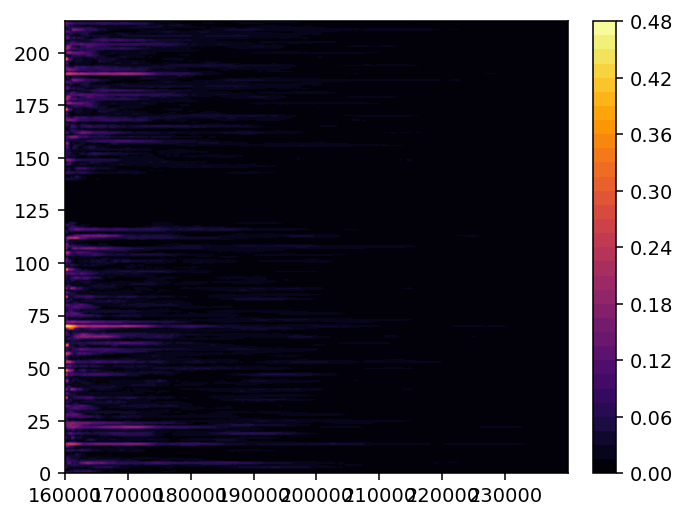

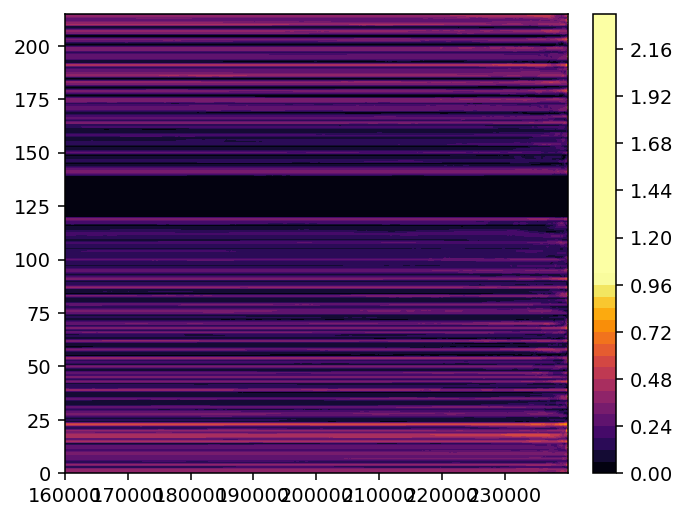

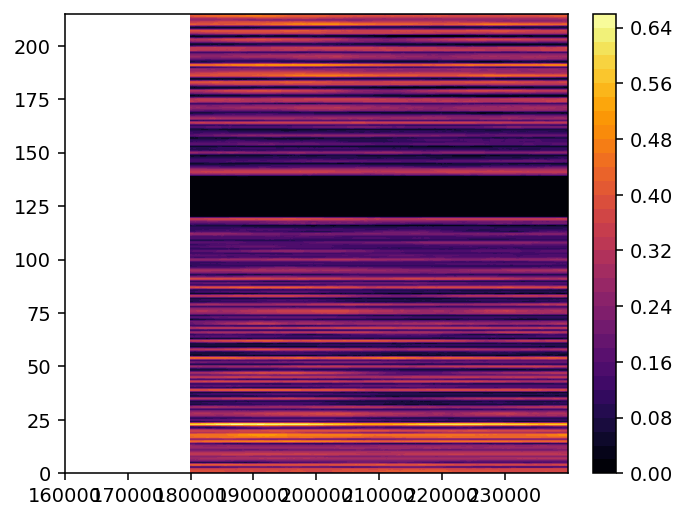

: 

In [9]:
for i, start in enumerate(starts):
    stop = stops[i]
    
    data = probes.statistics(
        names = [name for name in probes.probe_names if "door" not in name and "room" not in name], 
        steps = probes.probe_steps[start:stop:by],
        quants = qois,
        processing = [],
        parrallel=False
        )
    xPlot = data.index.values
    yPlot = np.arange(len(data.keys()))
    # if i == 0:

    #     fig, ax=plt.subplots(1, 1, constrained_layout = True)
    #     im=ax.scatter(flowStats.loc[data.keys(), 'x'], flowStats.loc[data.keys(), 'z'], s=4, c=yPlot, cmap='tab20c', edgecolors="black", linewidths=.1)
    #     fig.colorbar(im)
    #     plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/dataMap', bbox_inches="tight")

    dataCumMean = probePost.cumulative_mean(data)

    fig, ax = plt.subplots(constrained_layout = True)
    im = ax.contourf(xPlot, yPlot, dataCumMean.abs().T, cmap = "inferno", levels=40)
    fig.colorbar(im)
    # ax.set_yticks(yPlot)
    # ax.set_yticklabels(dataCumMean.keys())

    plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourCumMean_{start}-{stop}', bbox_inches="tight")

    dataConv = probePost.convergence(dataCumMean)

    fig, ax = plt.subplots(constrained_layout = True)
    im = ax.contourf(xPlot, yPlot, dataConv.abs().T, cmap = "inferno", levels=40)
    fig.colorbar(im)

    plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourConv_{start}-{stop}', bbox_inches="tight")

    dataRevCumMean = probePost.reverse(data)
    dataRevCumMean = probePost.cumulative_mean(dataRevCumMean)
    dataRevCumMean = probePost.reverse(dataRevCumMean)

    fig, ax = plt.subplots(constrained_layout = True)
    im = ax.contourf(xPlot, yPlot, dataRevCumMean.abs().T, cmap = "inferno", levels=40, vmax = 1)
    fig.colorbar(im)

    plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourRevCumMean_{start}-{stop}', bbox_inches="tight")

        
    dataSMA = sma(data)

    fig, ax = plt.subplots(constrained_layout = True)
    im = ax.contourf(xPlot, yPlot, dataSMA.abs().T, cmap = "inferno", levels=40)
    fig.colorbar(im)

    plt.savefig(f'{home_dir}/CHARLES/{category}/R{run}/plots/contourSMA_{start}-{stop}', bbox_inches="tight")